# Predict Unemployment Rate with Google Search Data and Intuition: A Simple Bayesian Regression Approach

COVID-19 has severely impacted the US economy.  Unemployment benefit claims surged suddenly in a short time.  The market is speculating about the unemployment rate when the Job Friday for March comes on April 3.  This notebook uses a well-documented appraoch to provide a quick and dirty estimate of the unemployment rate before a more accurate number is released.

The model uses a simple Bayesian regression technique that associates Google search freqeuncy for "Unemployment Benefits" with the unemployment rate.  With a prior heavily skewed towards the most recently reported number -- which provides the model an inertia, the model projects that the unemployment rate will lie between 8.2% to 10.6% with 80% chances.  This means that the unemployment rate can possibly increase from a 10-year low all the way to the peak level during the Financial Crisis.  An alternative specification that uses Gamma likelihood suggests a similar results, implying a 7% to 11.7% range.

## Install Prerequisites

In [1]:
! pip install pytrends
! pip install pystan
! pip install arviz

## Download Google Trend Data

In [0]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)
kw_list = ["Unemployment Benefits"]
pytrends.build_payload(kw_list, cat=0, timeframe='2004-01-01 2020-03-26', geo='', gprop='')
search = pytrends.interest_over_time().rename(columns = {'Unemployment Benefits': 'search'})

## Download Unemployment Rate Data from FRED 

In [0]:
import pandas_datareader as pdr
unrate = pdr.get_data_fred('UNRATE', start = "2004-01-01")

In [0]:
data = search.join(unrate)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'Monthly Unemployment Rate')

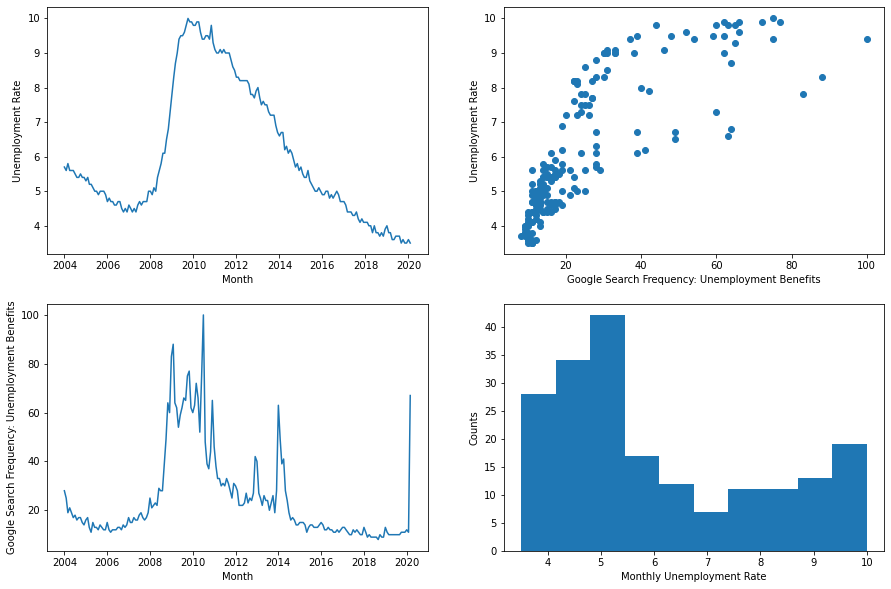

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)


ax1.plot(data['UNRATE'])
ax3.plot(data['search'])
ax2.scatter(x = data['search'], y = data['UNRATE'])
ax4.hist(data['UNRATE'])

ax1.set_ylabel('Unemployment Rate')
ax1.set_xlabel('Month')

ax3.set_ylabel('Google Search Frequency: Unemployment Benefits')
ax3.set_xlabel('Month')

ax2.set_xlabel('Google Search Frequency: Unemployment Benefits')
ax2.set_ylabel('Unemployment Rate')

ax4.set_ylabel('Counts')
ax4.set_xlabel('Monthly Unemployment Rate')

## Prepare Data for Stan

In [0]:
import numpy as np
train_data = data[:-1]
pred_data = data[-1:]

x_raw = train_data['search'].values
x_bar = np.mean(x_raw)
x_sd = np.sqrt(np.var(x_raw))

x = (x_raw - x_bar)/x_sd
y = train_data['UNRATE'].values

x_pred = (pred_data['search'].values - x_bar)/x_sd

stan_data = dict(
    N = len(x),
    x = x,
    x2 = x**2,
    y = y,
    N_pred = len(x_pred),
    x_pred = x_pred,
    x2_pred = x_pred ** 2 
)

## Model Specification 1: Gaussian Regression

Priors:

$\alpha \sim N(3.5, 1)$;

$\beta_1 \sim logN(0, 1)$;

$\beta_2 \sim N(0, 10)$;

$\sigma \sim Gamma(2, 0.5)$;

Likelihood:

$y_i \sim N(\alpha + \beta_1 \cdot x_i + \beta_2 \cdot x_i^2, \sigma)$

In [0]:
gauss_model_code = """
data {
  int<lower=0> N;
  vector[N] x;
  vector<lower = 0>[N] x2;
  vector[N] y;
  int<lower=0> N_pred;
  vector[N_pred] x_pred;
  vector<lower = 0>[N_pred] x2_pred;
}
parameters {
  real alpha;
  real<lower=0> beta1;
  real beta2; 
  real<lower=0> sigma;
}
model {
  alpha ~ normal(3.5, 1);
  beta1 ~ lognormal(0, 1);
  beta2 ~ normal(0, 10);
  sigma ~ gamma(2, 0.5);
  y ~ normal(alpha + beta1 * x + beta2 * x2, sigma);
}
generated quantities {
  vector[N_pred] y_pred;
  vector[N] log_lik;
  for (i in 1:N_pred){
    y_pred[i] = normal_rng(alpha + beta1 * x_pred[i] + beta2 * x2_pred[i], sigma);
  }
  for (i in 1:N) {
    log_lik[i] = normal_lpdf(y[i] |alpha + beta1 * x[i] + beta2 * x2[i], sigma);
  }
}
"""

In [8]:
import pystan

iter = 5000
model_gauss = pystan.StanModel(model_code=gauss_model_code)
trace_gauss = model_gauss.sampling(data=stan_data, chains = 4, iter = iter, warmup = int(np.floor(iter/10)), thin = 1, seed = 42)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b08c1522ff4fde8e95cfdc9c9a717b52 NOW.


In [9]:
print(trace_gauss.stansummary(pars = ['alpha', 'beta1', 'beta2', 'sigma', 'y_pred[1]']))

Inference for Stan model: anon_model_b08c1522ff4fde8e95cfdc9c9a717b52.
4 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=18000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       6.62  9.6e-4   0.09   6.45   6.56   6.62   6.68    6.8   8335    1.0
beta1       2.59  1.3e-3   0.12   2.35   2.51   2.59   2.67   2.82   8113    1.0
beta2      -0.59  6.5e-4   0.06   -0.7  -0.63  -0.59  -0.55  -0.48   7519    1.0
sigma       0.92  4.4e-4   0.05   0.83   0.89   0.92   0.95   1.02  11523    1.0
y_pred[1]   9.43  7.1e-3   0.94   7.59    8.8   9.44  10.06   11.3  17683    1.0

Samples were drawn using NUTS at Mon Mar 30 23:43:30 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98bc3f4550>,
      dtype=object)

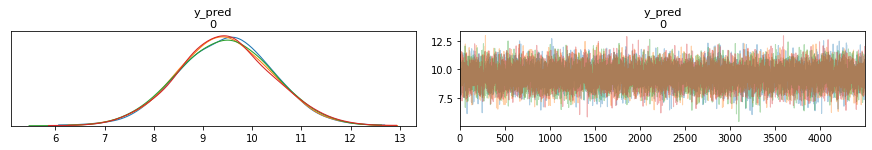

In [10]:
import arviz
arviz.plot_trace(trace_gauss, var_names = 'y_pred')

## Find 80% High Density Interval for Predicted Unemployment Rate 

In [11]:
p = 0.80

mcmc = trace_gauss.extract()
y_samp = mcmc['y_pred']
# rank order the draws
y_samp.reshape(1, -1)[0].sort()

# calculate the length of the CIs
ciIx = int(np.ceil(p * len(y_samp)))
nCIs = len(y_samp) - ciIx

# loop over all the CIs
ciWd = np.zeros(nCIs)
for i in range(nCIs):
  ciWd[i] = y_samp[i + ciIx] - y_samp[i]

# find the one with the shortest distance
hdiIx = np.argmin(ciWd)
print((y_samp[hdiIx][0], y_samp[hdiIx + ciIx][0]))

(8.240295835914601, 10.64984010907743)


## Model Specification 2: Gamma Regression
Priors:

$\alpha \sim N(0, 10)$;

$\beta_1 \sim logN(0, 1)$;

$\beta_2 \sim N(0, 10)$;

$\theta \sim Gamma(2, 0.5)$;

Likelihood:

$y_i \sim Gamma\left(\frac{\alpha + \beta_1 \cdot x_i + \beta_2 \cdot x_i^2}{\theta}, \theta\right)$

In [0]:
gamma_model_code = """
data {
  int<lower=0> N;
  vector[N] x;
  vector<lower = 0>[N] x2;
  vector[N] y;
  int<lower=0> N_pred;
  vector[N_pred] x_pred;
  vector<lower = 0>[N_pred] x2_pred;
}
parameters {
  real alpha;
  real<lower=0> beta1;
  real beta2; 
  real<lower=0> theta;
}
model {
  alpha ~ normal(0, 10);
  beta1 ~ lognormal(0, 1);
  beta2 ~ normal(0, 10);
  theta ~ gamma(2, 0.5);
  y ~ gamma((alpha + beta1 * x + beta2 * x2)/theta, theta);
}
generated quantities {
  vector[N_pred] y_pred;
  vector[N] log_lik;
  for (i in 1:N_pred){
    y_pred[i] = gamma_rng((alpha + beta1 * x_pred[i] + beta2 * x2_pred[i])/theta, theta);
  }
    for (i in 1:N) {
    log_lik[i] = gamma_lpdf(y[i] |(alpha + beta1 * x[i] + beta2 * x2[i])/theta, theta);
  }
}
"""

In [13]:
iter = 5000
model_gamma = pystan.StanModel(model_code=gamma_model_code)
trace_gamma = model_gamma.sampling(data=stan_data, chains = 4, iter = iter, warmup = int(np.floor(iter/10)), thin = 1, seed = 42)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a3f9f5d4314c27dee708be16134da4d5 NOW.


In [14]:
print(trace_gamma.stansummary(pars = ['alpha', 'beta1', 'beta2', 'theta', 'y_pred[1]']))

Inference for Stan model: anon_model_a3f9f5d4314c27dee708be16134da4d5.
4 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=18000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       54.4    0.11   6.42  42.12  50.05  54.28  58.64  67.39   3626    1.0
beta1      20.25    0.05   2.79  15.02  18.33  20.17  22.08  25.96   3798    1.0
beta2      -4.36    0.01    0.9  -6.21  -4.96  -4.33  -3.73  -2.68   4793    1.0
theta       2.86  2.8e-3   0.17   2.51   2.74   2.86   2.98    3.2   3768    1.0
y_pred[1]   9.48    0.01   1.85   6.23   8.19   9.37  10.63  13.49  17496    1.0

Samples were drawn using NUTS at Mon Mar 30 23:44:55 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98bb2e7438>,
      dtype=object)

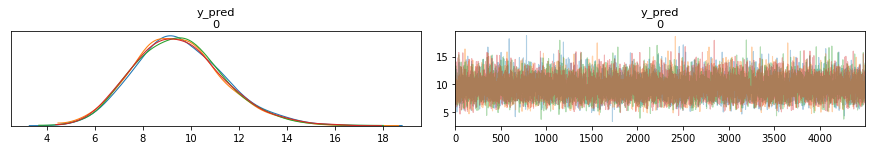

In [15]:
arviz.plot_trace(trace_gamma, var_names = 'y_pred')

In [16]:
p = 0.80

mcmc = trace_gamma.extract()
y_samp = mcmc['y_pred']
# rank order the draws
y_samp.reshape(1, -1)[0].sort()

# calculate the length of the CIs
ciIx = int(np.ceil(p * len(y_samp)))
nCIs = len(y_samp) - ciIx

# loop over all the CIs
ciWd = np.zeros(nCIs)
for i in range(nCIs):
  ciWd[i] = y_samp[i + ciIx] - y_samp[i]

# find the one with the shortest distance
hdiIx = np.argmin(ciWd)
print((y_samp[hdiIx][0], y_samp[hdiIx + ciIx][0]))

(6.873502283561022, 11.53289790748515)
